# Price Optimization Project for Company ABC

## Introduction

The purpose of this project is to analyze a pricing experiment conducted by Company ABC. The company divided its user base into two groups: Group A, constituting 66% of the users, and Group B, the remaining 34%. Group A received a lower price offer, while Group B was presented with a higher price for the same product.

The objectives of this analysis are to:

- Execute exploratory data analysis on the experimental data.
- Determine the statistical significance of the observed difference in conversion rates between the two groups via A/B testing.
- Identify an optimal price for the product to maximize revenue.
- Analyze user behavior and derive actionable insights to enhance conversion rates.
- Determine an optimal duration for running such tests to yield stable and reliable results.

This project utilizes two data sources: `test_results` and `user_table`. The `test_results` table contains information regarding user interactions on the site, the device used, the source of traffic, the price shown to the user, and the user's purchasing decision. The `user_table` includes geographical information about each user.

The subsequent sections encompass data cleaning and preprocessing, exploratory data analysis, hypothesis testing, user behavior analysis, and the provision of insights based on the findings.

## Importing Packages

In [1]:
# Import Necessary Libraries

# Data handling libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis libraries
from scipy import stats


%matplotlib inline


## Loading the Data

In [2]:
user_table = pd.read_csv(r"C:\Users\ramdh\Documents\GitHub\DS_Project\Other\Price Optimization Amazon DS Challenge\data\user_table.csv")
test_results = pd.read_csv(r"C:\Users\ramdh\Documents\GitHub\DS_Project\Other\Price Optimization Amazon DS Challenge\data\test_results.csv")

## Data Preprocessing

In [3]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

In [4]:
print("\nDuplicate rows in user_table:", user_table.duplicated().sum())
print("Duplicate rows in test_results:", test_results.duplicated().sum())


Duplicate rows in user_table: 0
Duplicate rows in test_results: 0


In [5]:
dataframe_info(user_table)

,Column,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
0,user_id,int64,275616,"[510335, 89568, 434134, 289769, 939586]",0,0.0
1,city,object,923,"[Peabody, Reno, Rialto, Carson City, Chicago]",0,0.0
2,country,object,1,[USA],0,0.0
3,lat,float64,713,"[42.53, 39.54, 34.11, 39.15, 41.84]",0,0.0
4,long,float64,830,"[-70.97, -119.82, -117.39, -119.74, -87.68]",0,0.0


In [22]:
user_table.shape

(275616, 5)

In [6]:
dataframe_info(test_results)

,Column,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
0,user_id,int64,316800,"[604839, 624057, 317970, 685636, 820854]",0,0.0
1,timestamp,object,140931,"[2015-05-08 03:38:34, 2015-05-10 21:08:46, 201...",0,0.0
2,source,object,12,"[ads_facebook, seo-google, ads-bing, direct_tr...",0,0.0
3,device,object,2,"[mobile, web]",0,0.0
4,operative_system,object,6,"[iOS, android, mac, windows, other]",0,0.0
5,test,int64,2,"[0, 1]",0,0.0
6,price,int64,2,"[39, 59]",0,0.0
7,converted,int64,2,"[0, 1]",0,0.0


In [7]:
test_results.shape

(316800, 8)

### Identifying and handling invalid timestamps

An issue was discovered when converting the 'timestamp' column to a datetime object, due to the presence of some invalid entries.

In [5]:
temp_df = test_results.copy(deep=True)
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], errors='coerce')

# Create a new DataFrame where the 'timestamp' column is NaT (Not a Time)
invalid_timestamps = temp_df[temp_df['timestamp'].isna()]

print("Number of invalid timestamps: ", invalid_timestamps.shape[0])

Number of invalid timestamps:  10271


These entries are invalid due to their incorrect format. For instance, timestamps such as '2015-04-24 12:60:46' have the minutes value outside the acceptable range (0-59). Such anomalies can arise from data entry errors or issues in the data collection process. 

In [6]:
anomaly_df = test_results.loc[invalid_timestamps.index]
anomaly_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
54,370914,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0
104,549807,2015-04-24 11:60:20,friend_referral,mobile,iOS,0,39,0
121,107010,2015-03-14 12:60:02,direct_traffic,web,windows,0,39,0
278,287830,2015-04-04 02:23:60,direct_traffic,web,windows,1,59,0
282,676183,2015-05-11 12:60:53,ads-google,web,windows,1,59,0


In [7]:
def correct_minute(value):
    try:
        pd.to_datetime(value)
        return value
    except:
        return value.replace("60", "59")

df_processed = test_results.copy(deep=True)

df_processed['timestamp'] = df_processed['timestamp'].apply(correct_minute)
df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

# df_processed.to_csv(r'C:\Users\ramdh\Documents\GitHub\DS_Project\price_optimization\data\processed\test_results_processed.csv', index=False)

In [8]:
del temp_df
del anomaly_df

# Exploratory Data Analysis

### Analysis of Conversion Rates by Product Price

In [9]:
# Overall Conversion Rate
overall_conversion_rate = df_processed['converted'].mean()

# Conversion Rate for users who saw the old price
old_price_conversion_rate = df_processed[df_processed['test'] == 0]['converted'].mean()

# Conversion Rate for users who saw the higher price
higher_price_conversion_rate = df_processed[df_processed['test'] == 1]['converted'].mean()

print("Overall Conversion Rate: ", overall_conversion_rate)
print("Conversion Rate for old price: ", old_price_conversion_rate)
print("Conversion Rate for higher price: ", higher_price_conversion_rate)

Overall Conversion Rate:  0.018333333333333333
Conversion Rate for old price:  0.019903614220108817
Conversion Rate for higher price:  0.015542678810936857


In [23]:
df_processed[['price', 'converted']].groupby('price').mean()

,converted
price,
39,0.019889
59,0.015570


The provided output illustrates the average conversion rates for the two product prices: $39 and $59.

At a price of $39, the conversion rate is approximately 1.99%. At $59, it decreases to about 1.56%. This suggests a slightly higher likelihood of product purchase at the lower price. However, this doesn't account for other influencing factors like traffic source, device, or operating system. Further multivariate analysis or predictive modeling is required for a more comprehensive understanding.

### Preliminary Assessment of Test Results and Identification of Anomalies

In [20]:
df_processed[['price', 'converted', 'test']].groupby(['test', 'price']).mean()

converted
test price           
0    39      0.019900
     59      0.023810
1    39      0.006452
     59      0.015555

The data table provided shows the conversion rates observed in the test and control groups, broken down by the price presented to the user.

In the control group (test=0), users who saw the price as $39 had a conversion rate of about 1.99%. This suggests that for any given user in the control group who was presented with a price of $39, there was a 1.99% chance they would make a purchase.

Interestingly, in the control group, users who saw the price as $59 had a slightly higher conversion rate of about 2.38%. This suggests that for any given user in the control group who was presented with a price of $59, there was a 2.38% chance they would make a purchase. It is unusual to observe a higher conversion rate for a higher price in the same group, suggesting there may be some inconsistencies in the data or other confounding factors influencing these results.

In the test group (test=1), users who saw the price as $39 had a conversion rate of about 0.645%. This implies that there was a 0.645% chance that a user in the test group who saw the $39 price would make a purchase.

For users in the test group who were shown a price of $59, the conversion rate was approximately 1.56%, suggesting a 1.56% chance that they would convert. Here, as expected, a higher price resulted in a lower conversion rate compared to the lower price in the same group.

This discrepancy in conversion rates given different prices within the same group (control or test) indicates the need for a closer examination of the data, or that there may be other variables at play that are affecting these results.

### Conversion Rates by Operating System and Product Price

In [24]:
df_processed[['price', 'converted', 'operative_system']].groupby(['price', 'operative_system']).mean()

converted
price operative_system           
39    android            0.016325
      iOS                0.023592
      linux              0.015413
      mac                0.025437
      other              0.014012
      windows            0.018688
59    android            0.012422
      iOS                0.019987
      linux              0.000000
      mac                0.021303
      other              0.011027
      windows            0.014008

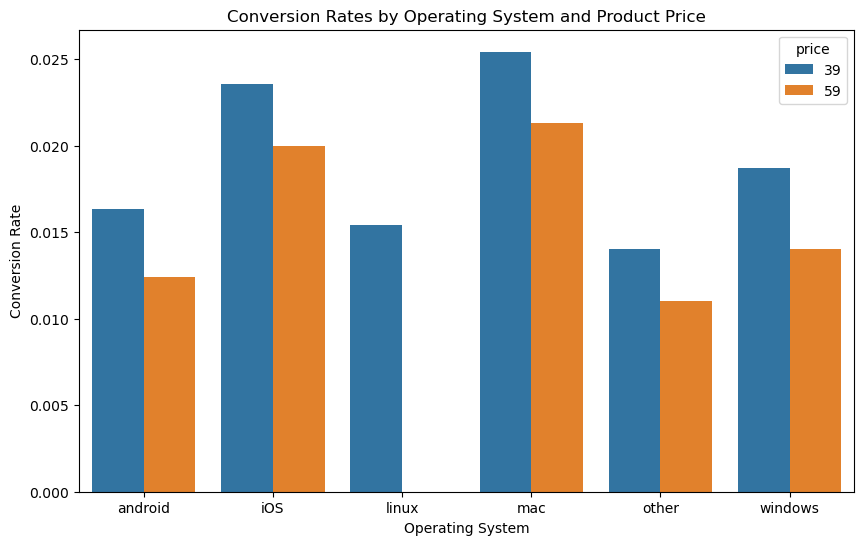

In [25]:
# Creating a new DataFrame for the grouped data
df_grouped = df_processed.groupby(['operative_system', 'price'])['converted'].mean().reset_index()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='operative_system', y='converted', hue='price', data=df_grouped)

plt.title('Conversion Rates by Operating System and Product Price')
plt.ylabel('Conversion Rate')
plt.xlabel('Operating System')
plt.show()

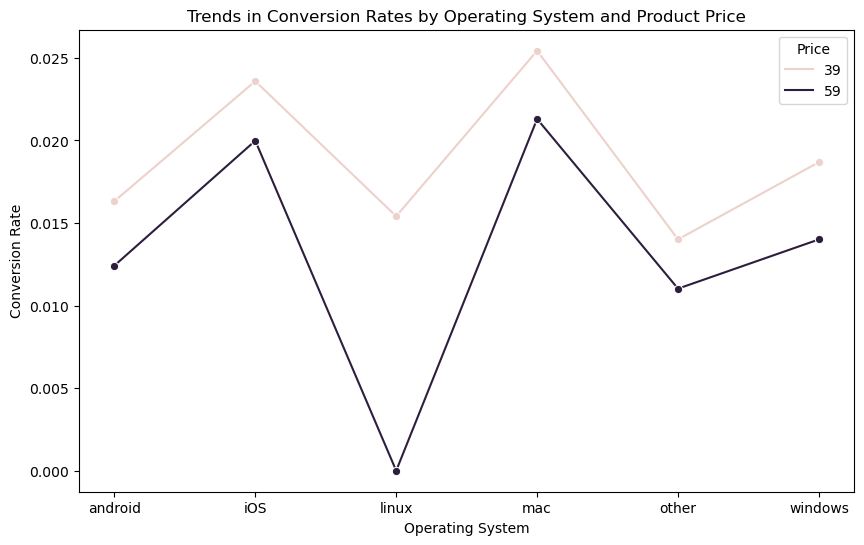

In [26]:
plt.figure(figsize=(10,6))
sns.lineplot(x='operative_system', y='converted', hue='price', data=df_grouped, marker='o')

plt.title('Trends in Conversion Rates by Operating System and Product Price')
plt.ylabel('Conversion Rate')
plt.xlabel('Operating System')
plt.legend(title='Price')
plt.show()


This table illustrates the conversion rates for each operative system at both price points. In general, iOS and Mac users exhibit higher conversion rates, potentially indicating a correlation between Apple users and a higher willingness to purchase the product. Interestingly, there is no conversion observed for Linux users at the $59 price point. Overall, the conversion rates for all operative systems appear to decrease when the price increases from $39 to $59.

In [12]:
dataframe_info(df_processed)

,Column,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
0,user_id,int64,316800,"[604839, 624057, 317970, 685636, 820854]",0,0.0
1,timestamp,datetime64[ns],140743,"[2015-05-08T03:38:34.000000000, 2015-05-10T21:...",0,0.0
2,source,object,12,"[ads_facebook, seo-google, ads-bing, direct_tr...",0,0.0
3,device,object,2,"[mobile, web]",0,0.0
4,operative_system,object,6,"[iOS, android, mac, windows, other]",0,0.0
5,test,int64,2,"[0, 1]",0,0.0
6,price,int64,2,"[39, 59]",0,0.0
7,converted,int64,2,"[0, 1]",0,0.0


## Feature Engineering

In [14]:
df_processed['hour'] = df_processed['timestamp'].dt.hour
df_processed['day'] = df_processed['timestamp'].dt.day
df_processed['month'] = df_processed['timestamp'].dt.month

### Target Encoding

In [17]:
df_processed[['price', 'converted']].groupby('price').mean()

,converted
price,
39,0.019889
59,0.015570


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss

In [ ]:
target = 'converted'
X_train, X_test, y_train, y_test = train_test_split(
    df_processed.drop(target, axis=1), df_processed[target] == "Yes", test_size=0.2, random_state=0
)